# Simulate `build_prediction` function - Version 2

Here we mimic the process used in the Inference Detection Layer:
- pick the class with highest probability from mrcnn_class, and it's corresponding bounding box delta
- apply the deltas to the rpn_roi (output_roi)
- convert to image pixel coordinates
-?? Should we apply intra-class NMS??

###  Env set up

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import sys, os, random, pprint
sys.path.append('../')

import tensorflow as tf
import keras.backend as KB
import numpy as np
import skimage.io

import mrcnn.visualize as visualize
import mrcnn.utils as utils

from mrcnn.datagen_mod     import data_generator, load_image_gt, data_gen_simulate
from mrcnn.callbacks       import get_layer_output_1,get_layer_output_2
from mrcnn.utils           import mask_string, parse_image_meta, apply_box_deltas_tf
from mrcnn.prep_notebook   import mrcnn_coco_test
from mrcnn.utils           import log

pp = pprint.PrettyPrinter(indent=2, width=100)
np.set_printoptions(linewidth=100,precision=4,threshold=1000, suppress = True)
## At this point, no default session exists

###  Build Inference Model

mrcnn_model, dataset_test, test_generator, mrcnn_config = mrcnn_coco_test(init_weights = 'coco')

###  Load Weights

# exclude=["mrcnn_class_logits"] # ,"mrcnn_bbox_fc"]   #, "mrcnn_bbox", "mrcnn_mask"])
exclude = None
mrcnn_model.load_model_weights(init_with = 'coco', exclude = exclude)  

###  Layer information

mrcnn_model.layer_info()
# model.keras_model.outputs[0].name

###  Get input images from generator and display

imgmeta_idx = mrcnn_model.keras_model.input_names.index('input_image_meta')

test_batch_x, test_batch_y = next(test_generator)
# test_batch_x, test_batch_y 

Using TensorFlow backend.


 Initialize CocoConfig object - super
 Linx  Linux
Tensorflow Version: 1.8.0   Keras Version : 2.1.6 
>>> Initialize ModelBase model 
   Mode:  inference
   Model dir :  /home/kbardool/models/mrcnn_coco_dev
>>> ModelBase initialiation complete
>>> ---Initialize MRCNN model, mode:  inference

>>> Resnet Graph 
     Input_image shape : (?, 1024, 1024, 3)
     After ZeroPadding2D  : (?, 1030, 1030, 3) (?, 1030, 1030, 3)
     After Conv2D padding : (?, 512, 512, 64) (?, 512, 512, 64)
     After BatchNorm      : (?, 512, 512, 64) (?, 512, 512, 64)
     C1 Shape: (?, 256, 256, 64) (?, 256, 256, 64)
     C2 Shape:  (?, 256, 256, 256) (?, 256, 256, 256)
     C3 Shape:  (?, 128, 128, 512) (?, 128, 128, 512)
     C4 Shape:  (?, 64, 64, 1024) (?, 64, 64, 1024)
     C5 Shape:  (?, 32, 32, 2048) (?, 32, 32, 2048)

>>> Feature Pyramid Network (FPN) Graph 
     FPN P2 shape : (None, 256, 256, 256)
     FPN P3 shape : (None, 128, 128, 256)
     FPN P4 shape : (None, 64, 64, 256)
     FPN P5 shape : (N

    No current tf default session 
    tf session initiated:  <tensorflow.python.client.session.Session object at 0x7f1fdc2c9940>
   Weights file loaded: /home/kbardool/PretrainedModels/mask_rcnn_coco.h5 
 MODEL Load weight file COMPLETE    
 MODEL Load weight file COMPLETE    


 Inputs:
 -------
 index:  0    input name : input_image:0                              Type: float32           Shape: (?, 1024, 1024, 3)
 index:  1    input name : input_image_meta:0                         Type: float32           Shape: (?, ?)


 Outputs:
 --------
 layer:  0    output name: mrcnn_detection/PyFunc:0                   Type: float32           Shape: <unknown>
 layer:  1    output name: ROI/rpn_roi_proposals:0                    Type: float32           Shape: (1, ?, ?)
 layer:  2    output name: mrcnn_class/Reshape_1:0                    Type: float32           Shape: (?, 1000, 81)
 layer:  3    output name: mrcnn_bbox/Reshape:0                       Type: float32           Shape: (?, 1000, 81,

Positives: 39, Extra: -89 
Negatives: 208478, Extra: 208261 


<IPython.core.display.Javascript object>


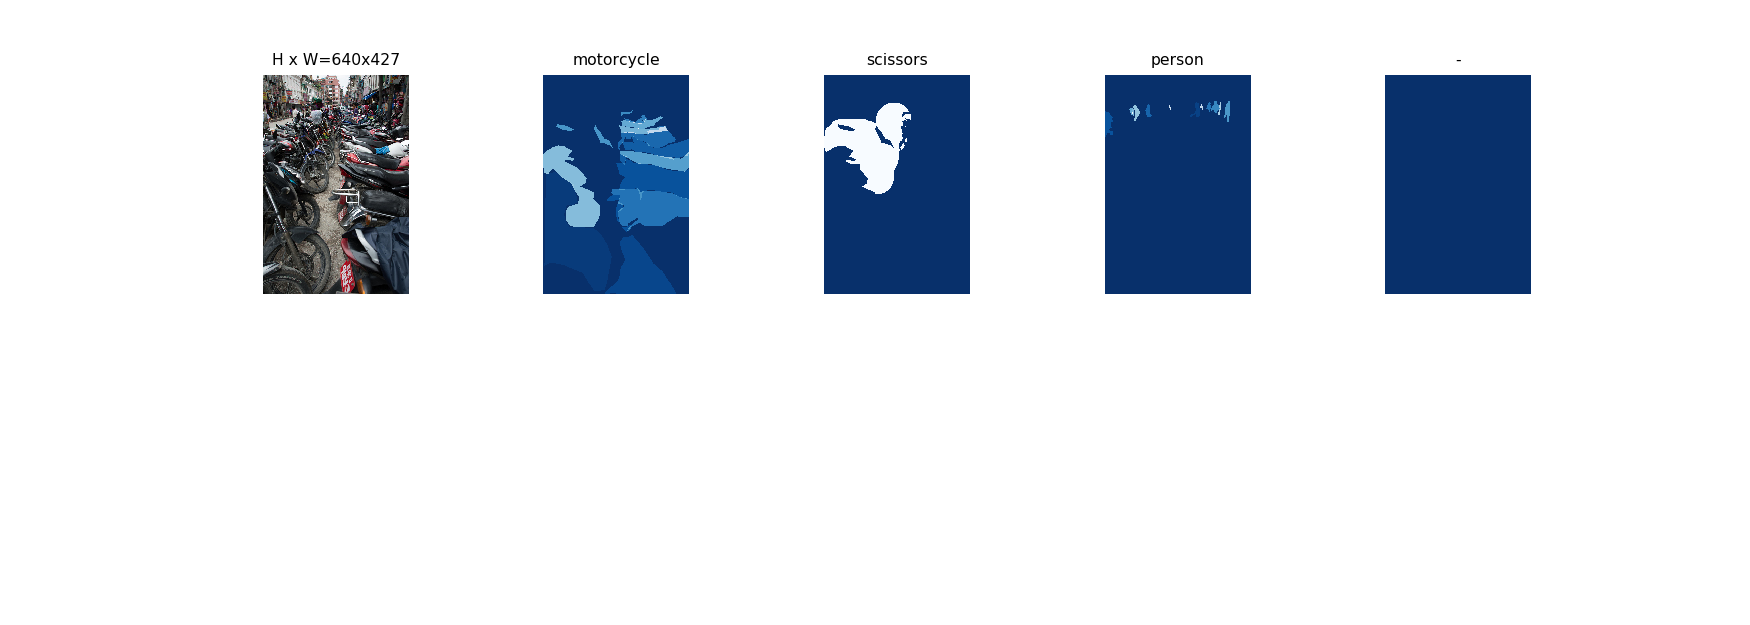

Image id:  5498   Image meta [5498  640  427    3    0  170 1024  853    1    1]
Classes :  ['person', 'person', 'motorcycle', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'motorcycle', 'motorcycle', 'motorcycle', 'motorcycle', 'motorcycle', 'motorcycle', 'motorcycle', 'motorcycle', 'motorcycle', 'motorcycle', 'motorcycle', 'person', 'person', 'person', 'motorcycle', 'scissors']


<IPython.core.display.Javascript object>


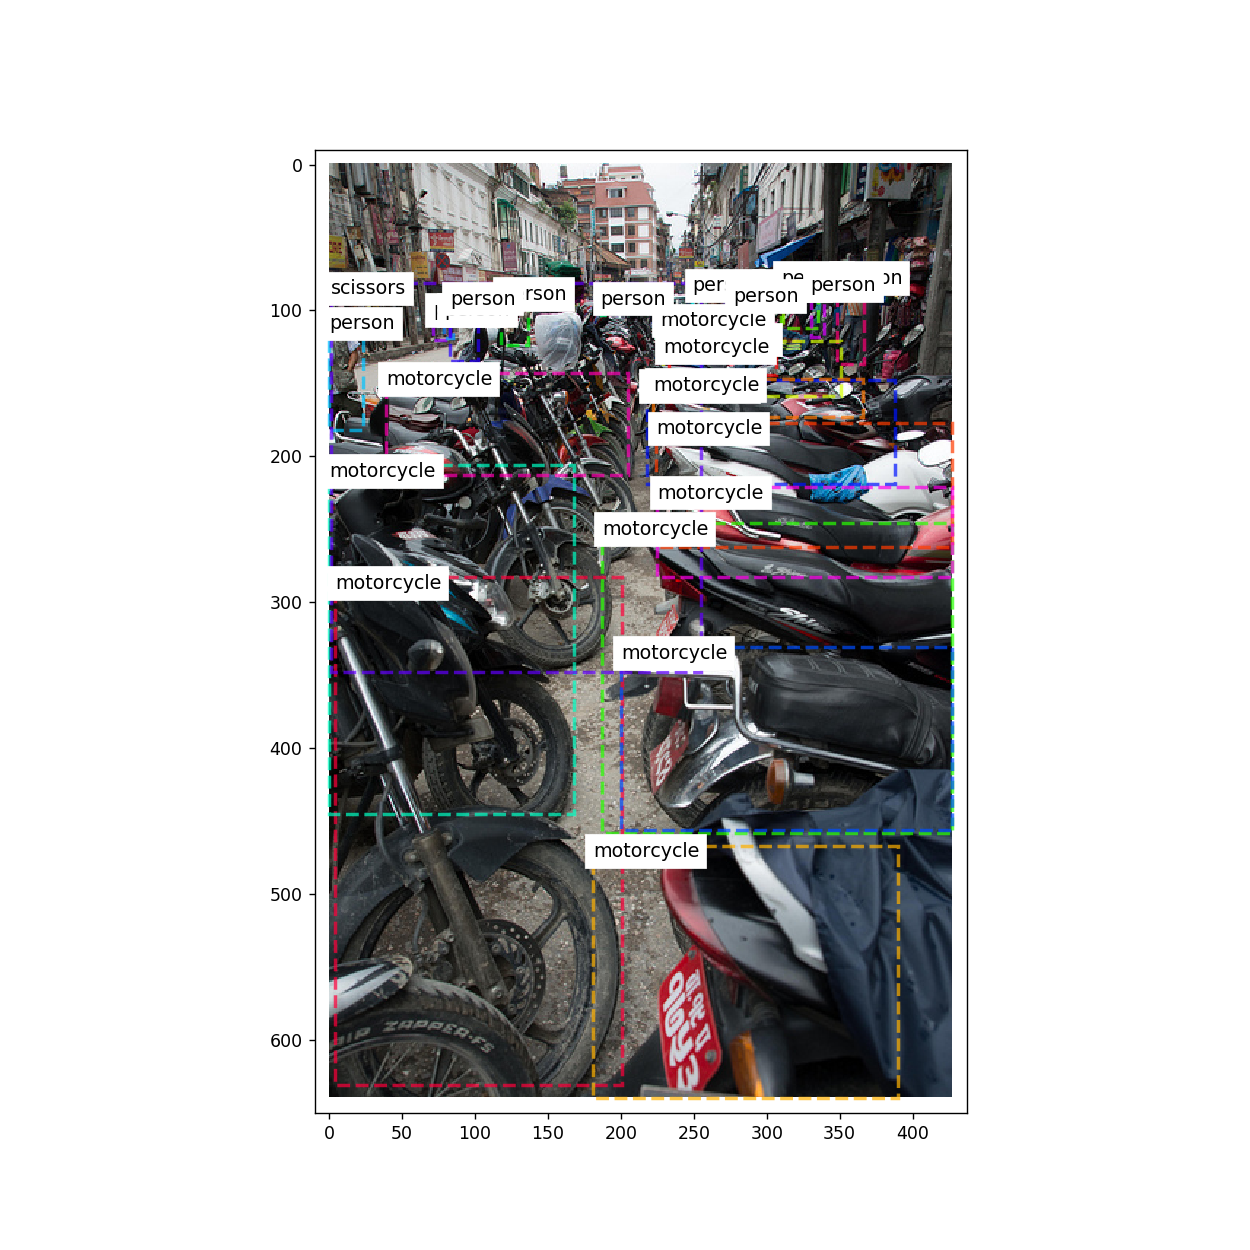

In [9]:
#5498 lots of motorcylces & persons - 
# Persons: #26026, #7719 
# 35347 - laptops, keyboards and cat

# test_batch_x, test_batch_y = next(test_generator)
test_batch_x, test_batch_y = data_gen_simulate(dataset_test, mrcnn_config, 5498)
img_meta    = test_batch_x[imgmeta_idx]

for img_idx in range(mrcnn_config.BATCH_SIZE):
    image_id = img_meta[img_idx,0]    
    image = dataset_test.load_image(image_id)
    mask, class_ids = dataset_test.load_mask(image_id)
    bbox = utils.extract_bboxes(mask)
    visualize.display_top_masks(image, mask, class_ids, dataset_test.class_names)
    print('Image id: ',image_id , '  Image meta', img_meta[img_idx,:10])
    print('Classes : ', [dataset_test.class_names[i] for i in class_ids])
    visualize.display_instances(image, bbox, class_ids, dataset_test.class_names,figsize=(10,10))

In [10]:
### Run computation graph 

#  model_output = get_layer_output_2(model.keras_model, train_batch_x, 1)
model_output = get_layer_output_1(mrcnn_model.keras_model, test_batch_x, [0,1,2,3], 0)

/* Inputs */
Input  0:  (input_image:0                           ) 	  Input shape: (1, 1024, 1024, 3)
Input  1:  (input_image_meta:0                      ) 	  Input shape: (1, 89)
    No current tf default session 
    tf session initiated:  <tensorflow.python.client.session.Session object at 0x7f1fdc2c9940>
    Wrapper for Detection Layer : call()  <class 'list'> 4
     rpn_proposals_roi  : (1, 1000, 4) <class 'numpy.ndarray'>
     mrcnn_class.shape  : (1, 1000, 81) <class 'numpy.ndarray'>
     mrcnn_bboxes.shape : (1, 1000, 81, 4) <class 'numpy.ndarray'>
     image_meta         : (1, 89) <class 'numpy.ndarray'>


 Detections are:
[[ 330.      170.     1005.      488.        4.        0.9968]
 [ 213.      519.      333.      826.        4.        0.9818]
 [ 229.      202.      535.      485.        4.        0.9806]
 [ 273.      501.      429.      848.        4.        0.9795]
 [ 414.      480.      994.      853.        4.        0.9462]
 [ 170.      530.      228.      688.        

In [12]:
### Load input and output tensors

input_image      =  test_batch_x[0]
input_image_meta =  test_batch_x[1]
print(' Input image shape is :', input_image.shape)
h, w = input_image.shape[1], input_image.shape[2]      #  tf.shape(input_image)[1], tf.shape(input_image)[2]

# gt_masks   =  test_batch_x[6]
print(input_image_meta)
print(' Len model_output: ',len(model_output))
detections                = model_output[0]          # layer:  0   shape: (1, 100, 6)
# rpn_roi_proposals         = model_output[1]          # layer:  1   shape: (1, 1000, 4)
# mrcnn_class               = model_output[2]          # layer:  4   shape: (1, 1000, 7)
# mrcnn_bbox                = model_output[3]          # layer:  5   shape: (1, 1000, 7, 4)
# rpn_class                 = model_output[2]          # layer:  2   shape: (1, 4092, 2)
# rpn_bbox                  = model_output[3]          # layer:  3   shape: (1, 4092, 4)
# pred_heatmap_norm         = model_output[6]          # layer:  6   shape: (1, 128, 128, 7)
# pred_heatmap_scores       = model_output[7]          # layer:  7   shape: (1, 7, 100, 11)
# pred_tensor               = model_output[8]          # layer:  8   shape: (1, 7, 100, 6)
# pred_heatmap              = model_output[9]          # layer:  9   shape: (1, 128, 128, 7)
# print(type(model_output[4]))
# print(type(output_rois))
for i in model_output:
    print( i.shape)
  

###  display Pred_Tensor, Pred_heatmap, mrcnn_class

np.set_printoptions(precision=4, threshold=None, linewidth=210, suppress=True)
img = 0
 
print(' detections  :', detections.shape)   # 1, 100, 6
print(detections[:,:50])    # output_rois * [128, 128,128,128])

# print(' rpn_roi_proposals : ', rpn_roi_proposals.shape)  # 1,1000,4
# print(' rpn_roi_proposals[0,:15]: \n', rpn_roi_proposals[0,:15] * [h, w,h,w])

# print(' mrcnn_class :',mrcnn_class.shape)   # 1,1000,81
# print( mrcnn_class[0,:5])

# print(' mrcnn_bbox  :', mrcnn_bbox.shape)   # 1,1000,81,4
# print( mrcnn_bbox[0,:5])

# print(' pred_tensor  :', pred_tensor.shape)   # 1, 100, 6
# print(pred_tensor[:,:,:5])    # output_rois * [128, 128,128,128])

# print(' pred_heatmap_scores  :', pred_heatmap_scores.shape)   # 1, 100, 6
# print(pred_heatmap_scores[:,:,:5])    # output_rois * [1024, 128,128,128])

# print(' rpn_class  : ', rpn_class.shape)                # 1,4092, 2
# print(' rpn_bbox   : ', rpn_bbox.shape)                 # 1,4092, 4 

 Input image shape is : (1, 1024, 1024, 3)
[[5498  640  427    3    0  170 1024  853    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1
     1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1
     1    1    1    1    1    1    1]]
 Len model_output:  4
(1, 100, 6)
(1, 1000, 4)
(1, 1000, 81)
(1, 1000, 81, 4)
 detections  : (1, 100, 6)
[[[ 330.      170.     1005.      488.        4.        0.9968]
  [ 213.      519.      333.      826.        4.        0.9818]
  [ 229.      202.      535.      485.        4.        0.9806]
  [ 273.      501.      429.      848.        4.        0.9795]
  [ 414.      480.      994.      853.        4.        0.9462]
  [ 170.      530.      228.      688.        4.        0.9425]
  [ 123.      6

####  Display `detections` tensor 

In [ ]:
np.set_printoptions(linewidth=150, precision=6)
# print('scatter shape is ', pred_scatt.get_shape())a
print('detection shape is ', detections.shape)
img = 0
for img in range(1):
    print('Image ', img , ' ------------')
    print(detections[img,:15] )

##  `build_predictions()`  tensor for inference mode ()


Sample `detections:`

`[ 43.        63.        80.        92.         4.         0.999993]
 [ 64.         7.        78.        42.         2.         0.99999 ]
 [  0.         0.         0.         0.         0.         0.      ]`

###  Setup tensors to be passed to `build_pred_tf ()`    

In [ ]:
print('Current Keras Session :', KB.query_session())

np.set_printoptions(linewidth=150, precision=6, threshold = 10000)
# mrcnn_bbox  = tf.identity(mrcnn_bbox)
# mrcnn_class = tf.identity(mrcnn_class)
sess = KB.get_session()
print('Session obtained from Keras', sess)

import mrcnn.utils as utils
detected_rois = tf.identity(detections)
config = mrcnn_config

###  Build `Pred_Tensor`

In [ ]:
with sess.as_default():
    
    batch_size      = config.BATCH_SIZE
    num_classes     = config.NUM_CLASSES
    h, w            = config.IMAGE_SHAPE[:2]
    num_rois        = config.DETECTION_MAX_INSTANCES 
    num_cols        = KB.int_shape(detected_rois)[-1]
    det_per_class   = 25
    print()
    print('  > build_predictions Inference mode ()')
    print('    config image shape  : ', config.IMAGE_SHAPE, 'h:',h,'w:',w)
    print('    num_rois            : ', num_rois )
    print('    num_cols            : ', num_cols )
    print('    detected_rois.shape : ', KB.int_shape(detected_rois))

# with sess.as_default():
    #---------------------------------------------------------------------------
    # Build a meshgrid for image id and bbox to use in gathering of bbox delta information 
    #   indexing = 'ij' provides matrix indexing conventions
    #---------------------------------------------------------------------------
    batch_grid, bbox_grid = tf.meshgrid( tf.range(batch_size, dtype=tf.int32),
                                         tf.range(num_rois, dtype=tf.int32), indexing = 'ij' )
#     print('    batch_grid: ', KB.int_shape(batch_grid))
#     print('    bbox_grid : ', KB.int_shape(bbox_grid))
#     print( batch_grid.eval())
#     print( bbox_grid.eval())
#     print(detected_rois)
#     print(detected_rois.eval()[0,:15])
    #---------------------------------------------------------------------------
    # column -2 contains the prediceted class 
    #  (NOT USED)   pred_classes_exp = tf.to_float(tf.expand_dims(pred_classes ,axis=-1))    
    #---------------------------------------------------------------------------
    pred_classes = tf.to_int32(detected_rois[...,-2])
    print(pred_classes.eval())

    #---------------------------------------------------------------------------
    #  stack batch_grid and bbox_grid - resulting array [0,0] ~ [0,99]
    #---------------------------------------------------------------------------    
    gather_ind   = tf.stack([batch_grid , bbox_grid],axis = -1)
    print('    gather_ind :', KB.int_shape(gather_ind))
#     print(gather_ind.eval())
    
    #-----------------------------------------------------------------------------------------------
    #  stack batch_grid, pred_classes, and bbox_grid - resulting array [0,cls_id, 0] ~ [0,cls_id / 0,99]
    #-----------------------------------------------------------------------------------------------
    scatter_ind = tf.stack([batch_grid , pred_classes, bbox_grid],axis = -1)
#     print('scatter_ind :', KB.int_shape(scatter_ind))
#     print(scatter_ind.eval())
    
    #-----------------------------------------------------------------------------------------------
    #  scatter detected_rois rows by class_id into pred_scatt  
    #-----------------------------------------------------------------------------------------------    
    pred_scatter  = tf.scatter_nd(scatter_ind, detected_rois, [batch_size, num_classes, num_rois, num_cols])
    print('    pred_scatter :', KB.int_shape(pred_scatter))
#     print(pred_scatter.eval()[0,57,:20,:])
    
    #------------------------------------------------------------------------------------
    ## sort pred_scatter in each class dimension based on sequence number (last column)
    #------------------------------------------------------------------------------------
    _, sort_inds = tf.nn.top_k(pred_scatter[...,-1], k=pred_scatter.shape[2])
    print('    sort_inds : ', KB.int_shape(sort_inds))
#     print(sort_inds.eval()[0,57,:20])
    
    #------------------------------------------------------------------------------------
    # build indexes to gather rows from pred_scatter based on sort order (sort_inds)
    #------------------------------------------------------------------------------------
    class_grid, batch_grid, roi_grid = tf.meshgrid(tf.range(num_classes),tf.range(batch_size), tf.range(num_rois))
    gather_inds  = tf.stack([batch_grid , class_grid, sort_inds],axis = -1)
 

#     print(' gather_inds :', KB.int_shape(gather_inds))
#     print(gather_inds.eval()[0,4,:])

    pred_tensor  = tf.gather_nd(pred_scatter, gather_inds[...,:det_per_class,:], name = 'pred_tensor')    
    print('     pred_tensor       ', pred_tensor.shape)  
    print(pred_tensor.eval()[0,4,:])


####  find value occuring with highest frequency in pred_classes

In [ ]:
tcf = tf.contrib.framework
with sess.as_default():
    print(pred_classes.eval())
    class_ids, idxs, class_counts = tf.unique_with_counts(pred_classes[0])
    print(class_ids.eval())
    print(class_counts.eval())
    print(idxs.eval())
    print('using bincount')
    bin_count = tf.bincount(pred_classes)[1:]
    print(bin_count.eval())
    
    print('using contrib.framework')
    argsort = tcf.argsort(bin_count, direction="DESCENDING")
    print(argsort.eval())
    
    
    print('using.top_k')
    print(tf.shape(class_counts).eval())
    sort_list, sort_inds = tf.nn.top_k(class_counts, k=tf.shape(class_counts)[0])
    print(sort_list.eval())
    print(sort_inds.eval())
          

####  Display for visual check - `pred_tensor` is the final result which is passed on to  `build_gaussian_tf()`

In [ ]:
with sess.as_default():
    np.set_printoptions(linewidth=150, precision=6)
    print('scatter shape is ', pred_scatter.get_shape())
    temp = pred_tensor
    print('pred_tensor shape is ', temp.shape)
    img = 0
    for k in range(4):
        print('Image ', img , '/ Class ',k,' ------------')
        print(temp[img,k].shape)

## `build_heatmap_inference()`

###  `build_mask_routine_inf()`

In [ ]:
##----------------------------------------------------------------------------------------------------------------------          
##
##----------------------------------------------------------------------------------------------------------------------          
    
def build_mask_routine_inf(input_list):
    '''
    Inputs:
    -----------
        heatmap_tensor :    [ image height, image width ]
        input_row      :    [y1, x1, y2, x2] in absolute (non-normalized) scale

    Returns
    -----------
        gaussian_sum :      sum of gaussian heatmap vlaues over the area covered by the bounding box
        bbox_area    :      bounding box area (in pixels)
        ratio        :      ratio of sum of gaussian to bbox area in pixels
                            The smaller the bounding box is , the larger the ratio
    '''
    heatmap_tensor, input_row = input_list
    with tf.variable_scope('mask_routine'):
        print(' input row is :' , input_row)
        # create array with cooridnates of current bounding box
        y_extent     = tf.range(input_row[0], input_row[2])
        x_extent     = tf.range(input_row[1], input_row[3])
        Y,X          = tf.meshgrid(y_extent, x_extent)
        bbox_mask    = tf.stack([Y,X],axis=2)        
        mask_indices = tf.reshape(bbox_mask,[-1,2])
        mask_indices = tf.to_int32(mask_indices)
        mask_size    = tf.shape(mask_indices)[0]
        mask_updates = tf.ones([mask_size], dtype = tf.float32)    
        mask         = tf.scatter_nd(mask_indices, mask_updates, tf.shape(heatmap_tensor))
#         mask_sum    =  tf.reduce_sum(mask)
        mask_applied = tf.multiply(heatmap_tensor, mask, name = 'mask_applied')
        bbox_area    = tf.to_float((input_row[2]-input_row[0]) * (input_row[3]-input_row[1]))
        gaussian_sum = tf.reduce_sum(mask_applied)
        ratio        = gaussian_sum * input_row[5]
#         ratio        = gaussian_sum / bbox_area 
#         ratio        = tf.where(tf.is_nan(ratio),  0.0, ratio)  
    return tf.stack([gaussian_sum, bbox_area, ratio], axis = -1)

### `build_heatmap_inference()`

In [ ]:
# def build_heatmap_inference(in_tensor, config, names = None):

names = ['pred_heatmap']
in_tensor = pred_tensor

with sess.as_default():
    num_detections  = config.DETECTION_MAX_INSTANCES
    img_h, img_w    = config.IMAGE_SHAPE[:2]
    batch_size      = config.BATCH_SIZE
    num_classes     = config.NUM_CLASSES 
    scale           = 1
    rois_per_image  = (in_tensor.shape)[2] 
    
    print('\n ')
    print('  > build_heatmap_inference() : ', names )
    print('    orignal in_tensor shape : ', in_tensor.shape)     
    # rois per image is determined by size of input tensor 
    #   detection mode:   config.TRAIN_ROIS_PER_IMAGE 
    #   ground_truth  :   config.DETECTION_MAX_INSTANCES

    # strt_cls        = 0 if rois_per_image == 32 else 1
    print('    num of bboxes per class is : ', rois_per_image )


    #-----------------------------------------------------------------------------    
    ## Stack non_zero bboxes from in_tensor into pt2_dense 
    #-----------------------------------------------------------------------------
    # pt2_ind shape is [?, 3]. 
    #   pt2_ind[0] corresponds to image_index 
    #   pt2_ind[1] corresponds to class_index 
    #   pt2_ind[2] corresponds to roi row_index 
    # pt2_dense shape is [?, 6]
    #    pt2_dense[0] is image index
    #    pt2_dense[1:4]  roi cooridnaytes 
    #    pt2_dense[5]    is class id 
    #-----------------------------------------------------------------------------
    pt2_sum = tf.reduce_sum(tf.abs(in_tensor[:,:,:,:-2]), axis=-1)
    print('    pt2_sum shape ',pt2_sum.shape)
    # print(pt2_sum[0].eval())
    
    pt2_ind = tf.where(pt2_sum > 0)
    print('    pt2_ind shape ', KB.int_shape(pt2_ind))
    print(pt2_ind.eval())

    pt2_dense = tf.gather_nd( in_tensor, pt2_ind)
    print('    pt2_dense shape ',pt2_dense.get_shape())
    print(pt2_dense.eval())

###  Build mesh grid and call `MultivariateNormalDiag()`

# with sess.as_default():
    #-----------------------------------------------------------------------------
    ## Build mesh-grid to hold pixel coordinates  
    #-----------------------------------------------------------------------------
    X = tf.range(img_w//scale, dtype=tf.int32)
    Y = tf.range(img_h//scale, dtype=tf.int32)
    X, Y = tf.meshgrid(X, Y)

    # duplicate (repeat) X and Y into a  batch_size x rois_per_image tensor
    ones = tf.ones([tf.shape(pt2_dense)[0] , 1, 1], dtype = tf.int32)
    rep_X = ones * X
    rep_Y = ones * Y 
    
    print('    X/Y shapes :',  X.get_shape(), Y.get_shape())
    print('    Ones:    ', ones.shape)                
    print('    ones_exp * X', ones.shape, '*', X.shape, '= ',rep_X.shape)
    print('    ones_exp * Y', ones.shape, '*', Y.shape, '= ',rep_Y.shape)
 
    #-----------------------------------------------------------------------------
    # # stack the X and Y grids 
    #-----------------------------------------------------------------------------
    pos_grid = tf.to_float(tf.stack([rep_X,rep_Y], axis = -1))
    print('    before transpse ', pos_grid.get_shape())
    pos_grid = tf.transpose(pos_grid,[1,2,0,3])
    print('    after transpose ', pos_grid.get_shape())    


    ## replaced the two operations below with the one above - 15-05-2018
    # pt2_mask = tf.greater(pt2_sum , 0)
    # pt2_ind  = tf.where(pt2_mask)
    # print(' pt2_mask shape ', pt2_mask.get_shape())
    # print(pt2_mask.eval())
    # print('    pt2_ind shape ', pt2_ind.get_shape())
    # print(pt2_ind.eval())

    #-----------------------------------------------------------------------------
    ##  Build mean and convariance tensors for Multivariate Normal Distribution 
    #-----------------------------------------------------------------------------
    width  = pt2_dense[:,3] - pt2_dense[:,1]      # x2 - x1
    height = pt2_dense[:,2] - pt2_dense[:,0]
    cx     = pt2_dense[:,1] + ( width  / 2.0)
    cy     = pt2_dense[:,0] + ( height / 2.0)
    means  = tf.stack((cx,cy),axis = -1)
    covar  = tf.stack((width * 0.5 , height * 0.5), axis = -1)
    covar  = tf.sqrt(covar)

    tfd = tf.contrib.distributions
    mvn = tfd.MultivariateNormalDiag(loc = means,  scale_diag = covar)
    prob_grid = mvn.prob(pos_grid)
    print('    Prob_grid shape before tanspose: ',prob_grid.get_shape())
    prob_grid = tf.transpose(prob_grid,[2,0,1])
    
    print('    Prob_grid shape after tanspose: ',prob_grid.get_shape())    
    print(' >> input to MVN.PROB: pos_grid (meshgrid) shape: ', pos_grid.get_shape())
    print(' << output probabilities shape:' , prob_grid.get_shape())

####  Check prob_grid for nan values

In [ ]:
with sess.as_default():
#     prob_grid_np = prob_grid.eval()
    nan_grid   = tf.is_nan(prob_grid)
    nan_any = tf.reduce_any(nan_grid).eval()
#     small_grid = tf.less(prob_grid , 1.0e-12).eval()
#     small_idx  = tf.where(prob_grid < 1.0e-12).eval()

print(nan_grid.shape)
# print(small_grid.shape)
# print(small_idx.shape)
print(nan_any)    
# print(np.any(small_grid))
# print(small_idx[0:40])
# print(prob_grid_np.shape)
# print(prob_grid_np[0,0,:40])
#     print(KB.int_shape(nan_grid.eval())
#     print(' nan_grid shape is :' , KB.int_shape(nan_grid), nan_grid.eval().shape):
#     print(np.sum(prob_grid.eval()[2]))

### Scatter Gaussians out to appropriate classes and apply reduce_sum

In [ ]:
with sess.as_default():
    #-------------------------------------------------------------------------------------
    ## IMPORTANT: kill distributions of NaN boxes (resulting from bboxes with height/width of zero
    ## which cause singular sigma cov matrices
    #-------------------------------------------------------------------------------------
    prob_grid = tf.where(tf.is_nan(prob_grid),  tf.zeros_like(prob_grid), prob_grid)


    #-------------------------------------------------------------------------------------
    # scatter out the probability distributions based on class 
    #-------------------------------------------------------------------------------------
    print('\n    Scatter out the probability distributions based on class --------------') 
    gauss_scatt   = tf.scatter_nd(pt2_ind, prob_grid, [batch_size, num_classes, rois_per_image, img_w, img_h], name='first_scatter')
    print('    pt2_ind shape   : ', pt2_ind.shape)  
    print('    prob_grid shape : ', prob_grid.shape)  
    print('    gauss_scatt     : ', gauss_scatt.shape)   # batch_sz , num_classes, num_rois, image_h, image_w
    
    #---------------------------------------------------------------------------
    # SUM : Reduce gauss_scattered by class  
    #---------------------------------------------------------------------------
    print('\n    Reduce sum based on class ---------------------------------------------')         
    gauss_sum = tf.reduce_sum(gauss_scatt, axis=2, name='pred_heatmap2')
#     gauss_sum = tf.where(gauss_sum > 1e-12, gauss_sum, tf.zeros_like(gauss_sum), name='Where1')
    print('    gaussian_sum shape     : ', gauss_sum.get_shape(), 'Keras tensor ', KB.is_keras_tensor(gauss_sum) )      
    
    

### Normalize `gauss_sum`  --> `gauss_norm`


    ##---------------------------------------------------------------------------------------------
    ## heatmap L2 normalization
    ## Normalization using the  `gauss_sum` (batchsize , num_classes, height, width) 
    ## 17-05-2018 (New method, replace dthe previous method that usedthe transposed gauss sum
    ## 17-05-2018 Replaced with normalization across the CLASS axis 
    ##---------------------------------------------------------------------------------------------
    # print('\n    L2 normalization ------------------------------------------------------')   
    # gauss_L2norm   = KB.l2_normalize(gauss_sum, axis = +1)   # normalize along the CLASS axis 
    # print('    gauss L2 norm   : ', gauss_L2norm.shape   ,' Keras tensor ', KB.is_keras_tensor(gauss_L2norm) )

    
    #---------------------------------------------------------------------------
    # gauss_sum normalization
    # normalizer is set to one when the max of class is zero 
    # this prevents elements of gauss_norm computing to nan
    #---------------------------------------------------------------------------
    print('\n    normalization ------------------------------------------------------')   
    normalizer = tf.reduce_max(gauss_sum, axis=[-2,-1], keepdims = True)
    normalizer = tf.where(normalizer < 1.0e-15,  tf.ones_like(normalizer), normalizer)
    gauss_norm    = gauss_sum / normalizer
     #   gauss_norm    = tf.where(tf.is_nan(gauss_norm),  tf.zeros_like(gauss_norm), gauss_norm, name = 'Where2')
    print('    gauss norm            : ', gauss_norm.shape   ,' Keras tensor ', KB.is_keras_tensor(gauss_norm) )


### Run `build_mask_routine()`


    ##--------------------------------------------------------------------------------------------
    ## generate score based on gaussian using bounding box masks 
    ## NOTE: Score is generated on NORMALIZED gaussian distributions (GAUSS_NORM)
    ##       If want to do this on NON-NORMALIZED, we need to apply it on GAUSS_SUM
    ##--------------------------------------------------------------------------------------------
    # flatten guassian scattered and input_tensor, and pass on to build_bbox_score routine 
    in_shape = tf.shape(in_tensor)
    
    # in_tensor_flattened  = tf.reshape(in_tensor, [-1, in_shape[-1]])  <-- not a good reshape style!!
    in_tensor_flattened  = tf.reshape(in_tensor, [-1, in_tensor.shape[-1]])
    
#     bboxes = tf.to_int32(tf.round(in_tensor_flattened[...,0:4]))
    
    print('    in_tensor             : ', in_tensor.shape)
    print('    in_tensor_flattened   : ', in_tensor_flattened.shape)
    print('    Rois per class        : ', rois_per_image)

    #--------------------------------------------------------------------------------------------------------------------------
    # duplicate GAUSS_NORM <num_roi> times to pass along with bboxes to map_fn function
    #   Here we have a choice to calculate scores using the GAUSS_SUM (unnormalized) or GAUSS_NORM (normalized)
    #   after looking at the scores and ratios for each option, I decided to go with the normalized 
    #   as the numbers are larger
    #
    # Examples>
    #   Using GAUSS_SUM
    # [   3.660313    3.513489   54.475536   52.747402    1.   0.999997    4.998889 2450.          0.00204     0.444867]
    # [   7.135149    1.310972   50.020126   44.779854    1.   0.999991    4.981591 1892.          0.002633    0.574077]
    # [  13.401865    0.         62.258957   46.636948    1.   0.999971    4.957398 2303.          0.002153    0.469335]
    # [   0.          0.         66.42349    56.123024    1.   0.999908    4.999996 3696.          0.001353    0.294958]
    # [   0.          0.         40.78952    60.404335    1.   0.999833    4.586552 2460.          0.001864    0.406513]    
    #                                                       
    #   Using GAUSS_NORM:                             class   r-cnn scr   
    # [   3.660313    3.513489   54.475536   52.747402    1.   0.999997 1832.9218   2450.          0.748131    0.479411]
    # [   7.135149    1.310972   50.020126   44.779854    1.   0.999991 1659.3965   1892.          0.877059    0.56203 ]
    # [  13.401865    0.         62.258957   46.636948    1.   0.999971 1540.4974   2303.          0.668909    0.428645]
    # [   0.          0.         66.42349    56.123024    1.   0.999908 1925.3267   3696.          0.520922    0.333813]
    # [   0.          0.         40.78952    60.404335    1.   0.999833 1531.321    2460.          0.622488    0.398898]
    # 
    #  to change the source, change the following line gauss_norm <--> gauss_sum
    #---------------------------------------------------------------------------------------------------------------------------
    

###  Call `build_mask_routine()` to build scores from `gauss_sum` and `gauss_norm`

Testing demonstrated that the we obtain the same NORMALIZED score from `gauss_sum` and `gauss_norm`
we will use the scores and heatmap generated from `gauss_norm` 

In [ ]:
with sess.as_default():
    ##--------------------------------------------------------------------------------------------
    #  Generate scores using GAUSS_SUM
    ##--------------------------------------------------------------------------------------------
    print()
    print('==== Scores from gauss_sum ================')
    temp = tf.expand_dims(gauss_sum, axis =2)
    print('    temp expanded shape       : ', temp.shape)

    temp = tf.tile(temp, [1,1, rois_per_image ,1,1])
    print('    temp tiled shape          : ', temp.shape)

    temp = KB.reshape(temp, (-1, temp.shape[-2], temp.shape[-1]))
    
    print('    temp flattened            : ', temp.shape)
    print('    in_tensor_flattened       : ', in_tensor_flattened.shape)

    scores_from_sum = tf.map_fn(build_mask_routine_inf, [temp, in_tensor_flattened], dtype=tf.float32)
    print('    Scores_from_sum (after build mask routine) : ', scores_from_sum.shape)   # [(num_batches x num_class x num_rois ), 3]    

    scores_shape    = [in_tensor.shape[0], in_tensor.shape[1],in_tensor.shape[2], -1]
    scores_from_sum = tf.reshape(scores_from_sum, scores_shape)    
    print('    reshaped scores       : ', scores_from_sum.shape)
    
    ##--------------------------------------------------------------------------------------------
    # shape of tf.reduce_max(bbox_scores[...,-1], axis = -1, keepdims=True) is (num_imgs, num_class, 1)
    #  This is a regular normalization that moves everything between [0, 1]. 
    #  This causes negative values to move to -inf, which is a problem in FCN scoring. 
    # To address this a normalization between [-1 and +1] was introduced in FCN.
    # Not sure how this will work with training tho.
    ##--------------------------------------------------------------------------------------------
    normalizer   = tf.reduce_max(scores_from_sum[...,-1], axis = -1, keepdims=True)
    normalizer   = tf.where(normalizer < 1.0e-15,  tf.ones_like(normalizer), normalizer)
    norm_score   = tf.expand_dims(scores_from_sum[...,-1]/normalizer, axis = -1)
    scores_from_sum = tf.concat([scores_from_sum, norm_score],axis = -1)
     
    print('    norm_score            : ', norm_score.shape)
    print('    scores_from_sum final : ', scores_from_sum.shape)

In [ ]:
with sess.as_default():
    ##--------------------------------------------------------------------------------------------
    #  Generate scores using normalized GAUSS_SUM -- GAUSS_NORM
    ##--------------------------------------------------------------------------------------------
    print('==== Scores from gauss_norm ================')
    temp = tf.expand_dims(gauss_norm, axis =2)
    print('    temp expanded shape       : ', temp.shape)
    
    temp = tf.tile(temp, [1,1, rois_per_image ,1,1])
    print('    temp tiled shape          : ', temp.shape)

    temp_reshape = KB.reshape(temp, (-1, temp.shape[-2], temp.shape[-1]))
    print('    temp flattened shape      : ', temp_reshape.shape)
    print('    in_tensor_flattened       : ', in_tensor_flattened.shape)
    
    scores_from_norm = tf.map_fn(build_mask_routine_inf, [temp_reshape, in_tensor_flattened], dtype=tf.float32)
    print('    Scores_from_norm (after build mask routine) : ', scores_from_norm.shape)   # [(num_batches x num_class x num_rois ), 3]    
    
    scores_shape    = [in_tensor.shape[0], in_tensor.shape[1],in_tensor.shape[2], -1]
    scores_from_norm = tf.reshape(scores_from_norm, scores_shape)    
    print('    reshaped scores       : ', scores_from_norm.shape)
    
    ##--------------------------------------------------------------------------------------------
    #  normalize score between [0, 1]. 
    ##--------------------------------------------------------------------------------------------
    normalizer   = tf.reduce_max(scores_from_norm[...,-1], axis = -1, keepdims=True)
    normalizer   = tf.where(normalizer < 1.0e-15,  tf.ones_like(normalizer), normalizer)
    
    print('    normalizer            : ',normalizer.shape)
    norm_score   = tf.expand_dims(scores_from_norm[...,-1]/normalizer, axis = -1)
    scores_from_norm = tf.concat([scores_from_norm, norm_score],axis = -1)
         
    print('    norm_score            : ', norm_score.shape)
    print('    scores_from_norm final: ', scores_from_norm.shape)    

####  Display gauss_sum

In [ ]:
with sess.as_default():
#     np_gauss_sum = tf.reduce_sum(gauss_sum,axis=[2,3]).eval()
    np_gauss_sum = tf.reduce_sum(gauss_sum,axis=[2,3]).eval()
print(np_gauss_sum.shape)
print(np_gauss_sum)


#### Display gauss_norm

In [ ]:
# del np_gauss_sum
with sess.as_default():
    np_gauss_norm = tf.reduce_sum(gauss_norm,axis=[2,3]).eval()
print(np_gauss_norm.shape)
print(np_gauss_norm)


#### Check `scores` generated by `build_mask_routine`

In [ ]:
# with sess.as_default(): 
#     np_scores_sum  = scores_from_sum.eval()
#     np_scores_norm = scores_from_norm.eval()
print(np_scores_sum.shape , np_scores_norm.shape) 

both = np.concatenate((np_scores_sum, np_scores_norm), axis = -1)
print(both.shape)
print(both[0,1])
# print(np.sum(np_scores[24:43,0]))
del np_scores_sum
del np_scores_norm
del both

###  Append `in_tensor` and `scores_from_sum` to form `bbox_scores`

In [ ]:
with sess.as_default():    
    # consider the two new columns for reshaping the gaussian_bbox_scores
    
    bbox_scores = tf.concat([in_tensor, scores_from_sum], axis = -1,name = names[0]+'_scores')
    print('    in_tensor       : ', in_tensor.shape)
    print('    boxes_scores    : ', bbox_scores.shape)   
    print('   ', bbox_scores.name)
    print('    bbox_scores  (FINAL)    : ', bbox_scores.shape, ' Keras tensor ', KB.is_keras_tensor(bbox_scores) )     
    

In [ ]:
#     new_shape   = tf.shape(in_tensor)+ [0,0,0, tf.shape(scores)[-1]]        
#     bbox_scores = tf.reshape(bbox_scores, new_shape)
#     bbox_reshape = [in_tensor.shape[0], in_tensor.shape[1],in_tensor.shape[2],in_tensor.shape[3] + scores.shape[-1]]
#     bbox_scores = tf.reshape(bbox_scores, bbox_reshape)
#     print('    in_tensor shape         : ', in_tensor.shape)
#     print('    new shape is            : ', bbox_reshape)
#     print('    in_tensor_flattened     : ', in_tensor_flattened.shape)
#     print('    Scores shape            : ', scores.shape)   # [(num_batches x num_class x num_rois ), 3]
#     print('    boxes_scores (reshaped) : ', bbox_scores.shape)   
    
    ##--------------------------------------------------------------------------------------------
    ## Normalize computed score above, and add it to the heatmap_score tensor as last column
    ##--------------------------------------------------------------------------------------------
#     scr_L2norm   = tf.nn.l2_normalize(bbox_scores[...,-1], axis = -1)   # shape (num_imgs, num_class, num_rois)
#     scr_L2norm   = tf.expand_dims(scr_L2norm, axis = -1)
#     np_scr_L2norm = scr_L2norm.eval()
    
    ##--------------------------------------------------------------------------------------------
    # shape of tf.reduce_max(bbox_scores[...,-1], axis = -1, keepdims=True) is (num_imgs, num_class, 1)
    #  This is a regular normalization that moves everything between [0, 1]. 
    #  This causes negative values to move to -inf, which is a problem in FCN scoring. 
    # To address this a normalization between [-1 and +1] was introduced in FCN.
    # Not sure how this will work with training tho.
    ##--------------------------------------------------------------------------------------------
#     normalizer   = tf.reduce_max(bbox_scores[...,-1], axis = -1, keepdims=True)
#     normalizer   = tf.where(normalizer < 1.0e-15,  tf.ones_like(normalizer), normalizer)
#     scr_norm     = bbox_scores[...,-1]/normalizer
#     scr_norm     = tf.expand_dims(scr_norm, axis = -1, name="scr_norm_exp_dims")                             # shape (num_imgs, num_class, 32, 1)

    #--------------------------------------------------------------------------------------------
    # this normalization moves values to [-1, +1] which we use in FCN, but not here. 
    #--------------------------------------------------------------------------------------------    
    # reduce_max = tf.reduce_max(bbox_scores[...,-1], axis = -1, keepdims=True)
    # reduce_min = tf.reduce_min(bbox_scores[...,-1], axis = -1, keepdims=True)  ## epsilon    = tf.ones_like(reduce_max) * 1e-7
    # scr_norm   = (2* (bbox_scores[...,-1] - reduce_min) / (reduce_max - reduce_min)) - 1     
    # scr_norm   = tf.where(tf.is_nan(scr_norm),  tf.zeros_like(scr_norm), scr_norm, name = "Where4")  
    #--------------------------------------------------------------------------------------------
#     bbox_scores    = tf.concat([bbox_scores, scr_norm, scr_L2norm], axis = -1,name = names[0]+'_scores')    
#     print('    bbox_scores  (FINAL)    : ', bbox_scores.shape, ' Keras tensor ', KB.is_keras_tensor(bbox_scores) )      
    
    #     gauss_scores         = KB.identity(bbox_scores, name = names[0]+'_scores')    
    #     print('    gauss_scores       final shape : ', gauss_scores.shape      ,' Keras tensor ', KB.is_keras_tensor(gauss_scores) )  

###  Arrange gauss_heatmap

In [ ]:
with sess.as_default():
#     gauss_heatmap      = KB.identity(tf.transpose(gauss_sum,[0,2,3,1]), name = names[0])

    gauss_heatmap      = tf.transpose(gauss_sum,[0,2,3,1], name = names[0])
    gauss_heatmap_norm = tf.transpose(gauss_norm,[0,2,3,1], name = names[0])

    print('    gauss_heatmap       shape : ', gauss_heatmap.shape     ,' Keras tensor ', KB.is_keras_tensor(gauss_heatmap) )  
    print('    gauss_heatmap_norm  shape : ', gauss_heatmap_norm.shape,' Keras tensor ', KB.is_keras_tensor(gauss_heatmap_norm) )  
#     print(gauss_heatmap)
    
#     gauss_heatmap_norm   = KB.identity(tf.transpose(gauss_norm,[0,2,3,1]), name = names[0]+'_norm')
#     print('    gauss_heatmap_norm final shape : ', gauss_heatmap_norm.shape,' Keras tensor ', KB.is_keras_tensor(gauss_heatmap_norm) )  
#     gauss_heatmap_L2norm = KB.identity(tf.transpose(gauss_L2norm,[0,2,3,1]), name = names[0]+'_L2norm')
 
    print('    complete')


###  Simulate `build_mask_routine()`:


In [ ]:
with sess.as_default():
    heatmap_tensor = temp_reshape[25]
    input_row = bboxes[25]
    print(' input row is :' , input_row.eval())
    y_extent     = tf.range(input_row[0], input_row[2])
    x_extent     = tf.range(input_row[1], input_row[3])
    print(y_extent.eval())
    print(x_extent.eval())
    Y,X          = tf.meshgrid(y_extent, x_extent)
    bbox_mask    = tf.stack([Y,X],axis=2)       
#     print(bbox_mask.eval().shape)
#     print(bbox_mask.eval())
    mask_indices = tf.reshape(bbox_mask,[-1,2])    # reshape to [#positions in mask, 2]
#     print(mask_indices.eval().shape)
    mask_indices = tf.to_int32(mask_indices)
    mask_size    = tf.shape(mask_indices)[0]
    mask_updates = tf.ones([mask_size], dtype = tf.float32)    
    mask         = tf.scatter_nd(mask_indices, mask_updates, tf.shape(heatmap_tensor))
#     print(mask.shape)
#     mask_sum    =  tf.reduce_sum(mask)
#     print(mask_sum.eval())
     
    mask_applied = tf.multiply(heatmap_tensor, mask, name = 'mask_applied')
    bbox_area    = tf.to_float((input_row[2]-input_row[0]) * (input_row[3]-input_row[1]))
    np_bbox_area = bbox_area.eval()
    gaussian_sum = tf.reduce_sum(mask_applied)
    ratio        = gaussian_sum * input_row[5]
#     np_gaussian_sum = gaussian_sum.eval()
#     ratio        = gaussian_sum / bbox_area 
#     ratio        = tf.where(tf.is_nan(ratio),  0.0, ratio)  

In [ ]:
# print(utils.mask_string(np_mask[122:190,665:710]))
print(np_gaussian_sum)
with sess.as_default():
    np_sum = tf.reduce_sum(heatmap_tensor).eval()
    print(np_sum)
    print(heatmap_tensor.shape)

In [ ]:
with sess.as_default():
    print(scores2_reshape[0,1].eval())

In [ ]:
with sess.as_default():    


In [ ]:
bbox_scores  = tf.concat([in_tensor, scores_reshape, scores2_reshape], axis = -1)

In [ ]:
with sess.as_default():
    np_bbox_scores = bbox_scores.eval()

###  Current method for bbox_scores

In [ ]:
with sess.as_default():    
    # consider the two new columns for reshaping the gaussian_bbox_scores
    
    bbox_scores = tf.concat([in_tensor_flattened, scores], axis = -1)
    print('    boxes_scores            : ', bbox_scores.shape)   
    
#     new_shape   = tf.shape(in_tensor)+ [0,0,0, tf.shape(scores)[-1]]        
#     bbox_scores = tf.reshape(bbox_scores, new_shape)
    bbox_reshape = [in_tensor.shape[0], in_tensor.shape[1],in_tensor.shape[2],in_tensor.shape[3] + scores.shape[-1]]
    bbox_scores = tf.reshape(bbox_scores, bbox_reshape)
    print('    in_tensor shape         : ', in_tensor.shape)
    print('    new shape is            : ', bbox_reshape)
    print('    in_tensor_flattened     : ', in_tensor_flattened.shape)
    print('    Scores shape            : ', scores.shape)   # [(num_batches x num_class x num_rois ), 3]
    print('    boxes_scores (reshaped) : ', bbox_scores.shape)   
    
    ##--------------------------------------------------------------------------------------------
    ## Normalize computed score above, and add it to the heatmap_score tensor as last column
    ##--------------------------------------------------------------------------------------------
#     scr_L2norm   = tf.nn.l2_normalize(bbox_scores[...,-1], axis = -1)   # shape (num_imgs, num_class, num_rois)
#     scr_L2norm   = tf.expand_dims(scr_L2norm, axis = -1)
#     np_scr_L2norm = scr_L2norm.eval()
    
    ##--------------------------------------------------------------------------------------------
    # shape of tf.reduce_max(bbox_scores[...,-1], axis = -1, keepdims=True) is (num_imgs, num_class, 1)
    #  This is a regular normalization that moves everything between [0, 1]. 
    #  This causes negative values to move to -inf, which is a problem in FCN scoring. 
    # To address this a normalization between [-1 and +1] was introduced in FCN.
    # Not sure how this will work with training tho.
    ##--------------------------------------------------------------------------------------------
    normalizer   = tf.reduce_max(bbox_scores[...,-1], axis = -1, keepdims=True)
    normalizer   = tf.where(normalizer < 1.0e-15,  tf.ones_like(normalizer), normalizer)
    scr_norm     = bbox_scores[...,-1]/normalizer
    scr_norm     = tf.expand_dims(scr_norm, axis = -1, name="scr_norm_exp_dims")                             # shape (num_imgs, num_class, 32, 1)

    #--------------------------------------------------------------------------------------------
    # this normalization moves values to [-1, +1] which we use in FCN, but not here. 
    #--------------------------------------------------------------------------------------------    
    # reduce_max = tf.reduce_max(bbox_scores[...,-1], axis = -1, keepdims=True)
    # reduce_min = tf.reduce_min(bbox_scores[...,-1], axis = -1, keepdims=True)  ## epsilon    = tf.ones_like(reduce_max) * 1e-7
    # scr_norm   = (2* (bbox_scores[...,-1] - reduce_min) / (reduce_max - reduce_min)) - 1     
    # scr_norm   = tf.where(tf.is_nan(scr_norm),  tf.zeros_like(scr_norm), scr_norm, name = "Where4")  
    #--------------------------------------------------------------------------------------------
    bbox_scores    = tf.concat([bbox_scores, scr_norm, scr_L2norm], axis = -1,name = names[0]+'_scores')    
    print('    bbox_scores  (FINAL)    : ', bbox_scores.shape, ' Keras tensor ', KB.is_keras_tensor(bbox_scores) )      
    
    #     gauss_scores         = KB.identity(bbox_scores, name = names[0]+'_scores')    
    #     print('    gauss_scores       final shape : ', gauss_scores.shape      ,' Keras tensor ', KB.is_keras_tensor(gauss_scores) )  

###  Arrange gauss_heatmap

with sess.as_default():
#     gauss_heatmap      = KB.identity(tf.transpose(gauss_sum,[0,2,3,1]), name = names[0])
    gauss_heatmap      = tf.transpose(gauss_sum,[0,2,3,1], name = names[0])
    print('    gauss_heatmap_norm final shape : ', gauss_heatmap.shape,' Keras tensor ', KB.is_keras_tensor(gauss_heatmap) )  
    print(gauss_heatmap)
    
#     gauss_heatmap_norm   = KB.identity(tf.transpose(gauss_norm,[0,2,3,1]), name = names[0]+'_norm')
#     print('    gauss_heatmap_norm final shape : ', gauss_heatmap_norm.shape,' Keras tensor ', KB.is_keras_tensor(gauss_heatmap_norm) )  
#     gauss_heatmap_L2norm = KB.identity(tf.transpose(gauss_L2norm,[0,2,3,1]), name = names[0]+'_L2norm')
 
    print('    complete')

#     return   gauss_heatmap_norm, gauss_scores  # , gauss_heatmap   gauss_heatmap_L2norm    # [gauss_sum, gauss_scatt, means, covar]    
    

#### Check bbox_scores generated

In [ ]:
with sess.as_default():
#     np_bbox_scores = bbox_scores.eval()
    print(bbox_scores)
print(np_bbox_scores.shape)
print(np_bbox_scores[0,1,:,:])

####  Check normalized scores 

In [ ]:
#     np_normalizer = normalizer.eval()
#     np_scr_norm  = scr_norm.eval()

#  Since we corrected normalzier above, there is no need to check and replace nan values with 0

#     scr_norm     = tf.where(tf.is_nan(scr_norm),  tf.zeros_like(scr_norm), scr_norm, name = "Where3")     
#     np_scr_norm2 = scr_norm.eval()
  
# print(np_normalizer.shape)
# print(np_normalizer)
# with sess.as_default():
# np_scr_norm  = scr_norm.eval()

# print(np_scr_norm.shape)
# print(np.isnan(np_scr_norm))
# print(np_scr_norm)

# print(np_scr_norm2.shape)
# print(np.isnan(np_scr_norm2))

# print(np_scr_L2norm.shape)
# print(np.isnan(np_scr_norm))

### Display heatmap for `gauss_sum` and `gauss_norm`

In [ ]:
# del np_gauss_norm, np_gauss_sum, np_in_tensor, np_bbox_scores
with sess.as_default():
#     np_gauss_sum = gauss_sum.eval()
    np_in_tensor = in_tensor.eval()
#       np_gauss_map = gauss_heatmap_norm.eval()
print(np_gauss_map.shape, np_in_tensor.shape)
np_gauss_map = np.transpose(np_gauss_map, axes=(0,3,1,2))
print(np_gauss_map.shape, np_in_tensor.shape)

In [ ]:
from mrcnn.visualize import plot_3d_heatmap, plot_2d_heatmap,plot_bbox_heatmap_one_class, plot_gaussian
%matplotlib notebook

print('Image id: ',image_id)
img = 0
cls = 1
ttl = 'Non-normalized - image: {}'.format(img)
plot_gaussian( np_gauss_map, 0, [1,3,4], title = 'My figure', width = 7, height = 7)
# plot_bbox_heatmap_one_class(np_gauss_sum[img], np_in_tensor[img], class_id = cls, num_bboxes = 25, title = ttl, width = 20)

In [ ]:
# ttl = 'Non-normalized - image: {}'.format(img)
# plot_3d_heatmap(pred_heatmap[img], title = ttl, width = 20)
# ttl = 'Normalized - image: {}'.format(img)
# plot_3d_heatmap(pred_heatmap_norm[img], title = ttl, width = 20)

# ttl = 'Non-normalized - image: {}'.format(img)
# plot_3d_heatmap(fcn_heatmap[img], title = ttl, width = 20)
# ttl = 'Normalized - image: {}'.format(img)
# plot_3d_heatmap(fcn_heatmap_norm[img], title = ttl, width = 20)

# ttl = 'Ground Truth Non-normalized - image: {}'.format(img)
# plot_3d_heatmap(gt_heatmap[img], title = ttl, width = 20)
# ttl = 'Ground Truth Normalized - image: {}'.format(img)
# plot_3d_heatmap(gt_heatmap_norm[img], title = ttl, width = 20)

# ttl = 'Non-normalized - image: {}'.format(img)
# plot_2d_heatmap(pred_heatmap[img], pred_heatmap_scores[img], width=15, title=ttl)
# ttl = 'Normalized - image: {}'.format(img)
# plot_2d_heatmap(pred_heatmap_norm[img], pred_heatmap_scores[img], width=15, title=ttl)

####  Display for visual check - `pred_heatmap_scores` is the final result which is passed from  `build_gaussian_tf()`

In [ ]:
# with sess.as_default():
np.set_printoptions(linewidth=150, precision=6, suppress=True)
# print('scatter shape is ', pred_scatt.get_shape())
print('pred_heatmap_scores shape is ', pred_heatmap_scores.shape)
for img in [0,1,2]:
    for k in range(4):
        print('Image ', img , '/ Class ',k,' ------------')
        print(np.min(pred_heatmap_scores[img,k,:,8]))
        print(pred_heatmap_scores[img,k])

####  Display for visual check - `GT_HEATMAP_SCORES` is the final result which is passed on to  `build_gaussian_tf()`

In [ ]:
np.set_printoptions(linewidth=150, precision=6)
print('gt_heatmap_scores shape is ', gt_heatmap_scores.shape)
img = 1
for k in range(4):
    print('Image ', img , '/ Class ',k,' ------------')
    print(gt_heatmap_scores[img,k])

####  Display for visual check - `pred_heatmap_norm` is the final result from  `build_gaussian_tf()`

In [ ]:
print(pred_heatmap_norm.shape)
temp = pred_heatmap_norm
np.set_printoptions(linewidth=150, threshold=10000, suppress=False)
print('  Temp shape :',  temp.shape)
temp_sum = np.sum(temp,axis=(1,2))
print('temp_sum is ', temp_sum.shape)
for i in range(5):
    for j in range(4):
        print('img ',i,' class ', j, ' sum:',temp_sum[i,j],  ' max: ',np.max(temp[i,:,:,j]),' mean: ', np.mean(temp[i,:,:,j]),' min: ', np.min(temp[i,:,:,j]))    


####  Display for visual check - `fcn_heatmap_norm` is the final result from  `FCN`

In [ ]:
temp = fcn_heatmap
print('  Temp shape :',  temp.shape)
temp_sum = np.sum(temp,axis=(1,2))
print('temp_sum is ', temp_sum.shape)
for i in range(5):
    for j in range(4):
        print('img / cls ',i,'/', j, ' sum:',temp_sum[i,j])
        print('sum: ', np.sum(temp[i,:,:,j] ),' max: ',np.max(temp[i,:,:,j]),' mean: ', np.mean(temp[i,:,:,j]),' min: ', np.min(temp[i,:,:,j]))    

#### Display sum, min, max of heatmaps

In [ ]:
sess = KB.get_session()
with sess.as_default():
    temp = fcn_heatmap
    np.set_printoptions(linewidth=150, threshold=10000)
    print('  output shapes :',  temp.get_shape())
    temp_sum = tf.reduce_sum(temp, [2,3])
    temp_min = tf.reduce_min(temp, [2,3])
    temp_max = tf.reduce_max(temp, [2,3])
    temp_avg = tf.reduce_mean(temp, [2,3])
    print('temp_sum is ', temp_sum.shape)
    for i in range(5):
        for j in range(4):
                print('img/cls ',i,'/', j,'  sum:',temp_sum[i,j], 'min',temp_min[i,j] ,'max',temp_max[i,j] ,'avg',temp_avg[i,j])


####  Display for visual check - `gt_heatmap_scores`  and `fcn_heatmap_scores` 

In [ ]:
# with sess.as_default():
np.set_printoptions(linewidth=150, precision=6)
# print('scatter shape is ', pred_scatt.get_shape())

img = 0
for i in [1,2,3]:
    for j in range(32):
        print('Image ', img , '/ Class ',i,' ------------')

        print(gt_heatmap_scores[img,i,j])
        print(pred_heatmap_scores[img,i,j])
        print(fcn_heatmap_scores[img,i,j,[0,1,2,3,4,5,11,12,13,14,15]])

## Display `gauss_heatmap` 3D heatmap (not normalized, normlized, L2 normalized)

In [ ]:
from mrcnn.visualize import plot_3d_heatmap, plot_2d_heatmap
%matplotlib inline
print('Image id: ',image_id , '    Classes (1: circle, 2: square, 3: triangle ): ')
img = 0
cls = 0

# for cls in range(7):
#     print(pred_heatmap_scores[img,cls,:10])

ttl = 'Non-normalized - image: {}'.format(img)
plot_3d_heatmap(pred_heatmap[img], title = ttl, width = 20)
ttl = 'Normalized - image: {}'.format(img)
plot_3d_heatmap(pred_heatmap_norm[img], title = ttl, width = 20)

# ttl = 'Non-normalized - image: {}'.format(img)
# plot_3d_heatmap(fcn_heatmap[img], title = ttl, width = 20)
# ttl = 'Normalized - image: {}'.format(img)
# plot_3d_heatmap(fcn_heatmap_norm[img], title = ttl, width = 20)

# ttl = 'Ground Truth Non-normalized - image: {}'.format(img)
# plot_3d_heatmap(gt_heatmap[img], title = ttl, width = 20)
# ttl = 'Ground Truth Normalized - image: {}'.format(img)
# plot_3d_heatmap(gt_heatmap_norm[img], title = ttl, width = 20)


# ttl = 'Non-normalized - image: {}'.format(img)
# plot_2d_heatmap(pred_heatmap[img], pred_heatmap_scores[img], width=15, title=ttl)
# ttl = 'Normalized - image: {}'.format(img)
# plot_2d_heatmap(pred_heatmap_norm[img], pred_heatmap_scores[img], width=15, title=ttl)


### Print out values of `pred_tensor` , `pred_array`, ..

In [ ]:
with sess.as_default():
    scatt = pred_scatt.eval()
    test = pred_tensor.eval()

####  Test that refined_rois is correctly working in `clip_to_window_tf` 

In [ ]:
with sess.as_default():
    test_np = refined_rois.eval()
    test_tf = refined_rois_clipped.eval()
    window_np = np.array([0,0,128,128])
 
    print(window_np.shape)
    for i in range(5):
#         print('Before', i)
#         print(test_np[i])
        test_np[i] = clip_to_window(window_np, test_np[i])
#         print('After', i)
#         print(test_np[i])
#         print('   tensor flow')
#         print(test_tf[i])
        
    for i in range(5):
      all_equal = np.all(test_np == refined_rois_clipped.eval())
      print('i: ', i, '--- EQUAL : ', all_equal)


####  Test that pred_classes and pred_deltas have been properly selected when using tf.gather_nd ()

In [ ]:
with sess.as_default():
    tmp0 = pred_classes.eval()
    tmp1 = mrcnn_bbox.eval()
    tmp2 = pred_deltas.eval()
    tmp4 = mrcnn_class.eval()
    tmp3 = pred_scores2.eval()
    tmp5 = pred_scores.eval()
    

for i in range(5):
    for j in range(32):
        print('i: ', i, ' j :', j,'--- class: ',tmp0[i,j],'---------------')
    #     print(tmp0[i,j])
        print(tmp1[i,j])
        print(' ===> ', tmp2[i,j])
        print(' mrcnn_score: ', tmp4[i,j,tmp0[i,j]], ' pred_score:', tmp5[i,j,0], 'pred_score2: ', tmp3[i,j])


####  Verify refined_rois generated by TF and NP are equal when using `apply_box_deltas_tf( )`

In [ ]:
from mrcnn.utils import apply_box_deltas, apply_box_deltas_tf
with sess.as_default():
    refined_rois_tf = apply_box_deltas_3d(output_rois, pred_deltas).eval()
    print(' refined rois_tf: ', refined_rois_tf.shape, refined_rois_tf.dtype)
    tmp = []
    bxs = output_rois.eval()
    dlt = pred_deltas.eval()
    for i in range(5):
        tmp.append(apply_box_deltas(bxs[i], dlt[i]))
    refined_rois_np = np.asarray(tmp)
    print(' refined rois_np: ', refined_rois_np.shape,refined_rois_np.dtype)
    print(' refined rois_np == refined rois_tf ?? :', np.all(refined_rois_tf[0,1] == refined_rois_np[0,1]))

#     for i in range(5):
#         for j in range(32):
#             all_eq = np.all(refined_rois_tf[0,1] == refined_rois_np[0,1])
#             if ~all_eq:
#                 print(' Not equal : ',i,'/',j)
#                 print(refined_rois_tf[i,j])
#                 print(refined_rois_np[i,j])
#             else:
#                 print(' equal : ',i,'/',j)
print(refined_rois_tf[0])
print(refined_rois_np[0])


#### Window manipulation 

In [ ]:
with sess.as_default():    
    X = tf.range(18, dtype=tf.int32)
    Y = tf.range(18, dtype=tf.int32)
    X, Y = tf.meshgrid(X, Y)

    # duplicate (repeat) X and Y into a  batch_size x rois_per_image tensor
    print('    X/Y shapes :',  X.get_shape(), Y.get_shape())
    ones = tf.ones([34 , 1, 1], dtype = tf.int32)
    rep_X = ones * X
    rep_Y = ones * Y 
    print('    Ones:    ', ones.shape)                
    print('    ones_exp * X', ones.shape, '*', X.shape, '= ',rep_X.shape)
    print('    ones_exp * Y', ones.shape, '*', Y.shape, '= ',rep_Y.shape)


In [ ]:
with sess.as_default():
    
    window          = tf.constant([[0,1,2,3]], dtype =tf.float32)   
    print(window.shape)
#     high_vals = tf.stack([window[:,2],window[:,3], window[:,2], window[:,3]], axis = -1)
#     print(' hv: ', high_vals.shape)
#     print(high_vals.eval())
    high_vals = tf.expand_dims(high_vals, axis = 1)
#     print(' hv: ', high_vals.shape)
    high_vals = tf.tile(high_vals,[1,32,1])    
#     print(high_vals.shape)
#     print(high_vals[0].eval())
#     print(high_vals[1].eval())
#     print(high_vals[2].eval())

    
    
    low_vals  = tf.stack([window[:,0],window[:,1], window[:,0], window[:,1]], axis = -1)
    print(' lv: ', low_vals.shape)
    print(low_vals.eval())
    low_vals = tf.expand_dims(low_vals, axis = 1)
    print(' lv: ', low_vals.shape)
    low_vals = tf.tile(low_vals,[5, 32,1])    
    print(' lv: ', low_vals.shape)
    print(low_vals[0].eval())
    print(low_vals[1].eval())
    print(low_vals[2].eval())     
    print(low_vals[3].eval())         
    print(low_vals[4].eval())     

###  Test `means`, `covar`, `gauss_grid`, and `gauss_sum ` between development version and final version

In [ ]:
print(pred_tensor.get_shape(), pred_tensor2.get_shape())
print(np.all(pred_tensor.eval() == pred_tensor2.eval()))
# tst1 = means.eval()
# tst2 = means2.eval()
# print(tst1.shape, tst2.shape)

# print(tst1[0,:10])
# print()
# print(tst2[0,:10])
# print(np.all(tst1 == tst2))
# print()
# del tst1, tst2

In [ ]:
print(output_rois.eval())

## Proposal Layer

In [ ]:
import mrcnn.utils as utils
sess = KB.get_session()


In [ ]:
def apply_box_deltas_graph(boxes, deltas):
    """
    Applies the given deltas to the given boxes.

    x,y,w,h : Bounding Box coordinates, width, and height

    Boxes:  is the (y1, x1, y2, x2) of the anchor boxes
    deltas: [dy, dx, log(dh), log(dw)] 
            is the predicted bounding box returned from the RPN layer (in test phase)
            These are considered the targets or ground truth 
    Refer to Bounding Box Regression - R-CNN paper 
    Regression targets are calculated as follows:   
      tx = (GTx - PRx)/PRw       ty = (Gy - Py)/Ph
      th = log(Gw/Pw)         tw = log(Gh/Ph)
    ---------------------------------------------------------------------------------            
    
    boxes:  [N, 4] where each row is [y1, x1, y2, x2]
    deltas: [N, 4] where each row is [dy, dx, log(dh), log(dw)]
    """
    # Convert to y, x, h, w
    height   = boxes[:, 2] - boxes[:, 0]
    width    = boxes[:, 3] - boxes[:, 1]
    center_y = boxes[:, 0] + 0.5 * height
    center_x = boxes[:, 1] + 0.5 * width
    
    # Apply deltas
    center_y += deltas[:, 0] * height
    center_x += deltas[:, 1] * width
    height   *= tf.exp(deltas[:, 2])
    width    *= tf.exp(deltas[:, 3])
    
    # Convert back to y1, x1, y2, x2
    y1 = center_y - 0.5 * height
    x1 = center_x - 0.5 * width
    y2 = y1 + height
    x2 = x1 + width
    result = tf.stack([y1, x1, y2, x2], axis=1, name="apply_box_deltas_out")
    return result


def clip_boxes_graph(boxes, window):
    """
    clip refined anchor boxes such that they remain within the dimensions of the image 
    boxes:  [N, 4] each row is y1, x1, y2, x2
    window: [4] in the form y1, x1, y2, x2 
    """
    # Split corners
    wy1, wx1, wy2, wx2 = tf.split(window, 4)   #  0, 0 , 128,128
    y1 , x1 , y2 , x2  = tf.split(boxes, 4, axis=1)
    
    # Clip
    y1 = tf.maximum(tf.minimum(y1, wy2), wy1)   # ensure  wy1 <= y1 <= wy2
    x1 = tf.maximum(tf.minimum(x1, wx2), wx1)
    y2 = tf.maximum(tf.minimum(y2, wy2), wy1)
    x2 = tf.maximum(tf.minimum(x2, wx2), wx1)
    clipped = tf.concat([y1, x1, y2, x2], axis=1, name="clipped_boxes")
    return clipped

def suppress_small_boxes_graph(boxes, scores, area_threshold ):
    """
    supress boxes with area less than area_threshold
    boxes:  [N, 4] each row is y1, x1, y2, x2
    
    """
    bx_area = (boxes[...,2]-boxes[...,0])*(boxes[...,3]-boxes[...,1])
    selected_idxs   = tf.where(tf.greater_equal(bx_area, area_threshold))
    selected_boxes  = tf.gather_nd(boxes, selected_idxs)
    selected_scores = tf.gather_nd(scores, selected_idxs)
    padding   = tf.maximum(tf.shape(boxes)[0] - tf.shape(selected_boxes)[0], 0)

#     print(' box area       : ', bx_area.shape)    
#     print(' selected_idxs  : ', tf.shape(selected_idxs).eval())
#     print(' selected scores: ', tf.shape(selected_scores).eval())
#     print(' Req padding    : ', padding.eval())
    
    selected_boxes  = tf.pad(selected_boxes, [(0, padding), (0, 0)])    
    selected_scores = tf.pad(selected_scores, [(0, padding)])    
    return selected_boxes, selected_scores

def nms(normalized_boxes, scores):
    proposal_count = model.config.POST_NMS_ROIS_TRAINING
    rms_threshold  = model.config.RPN_NMS_THRESHOLD
    indices = tf.image.non_max_suppression(normalized_boxes, 
                                           scores, 
                                           proposal_count,
                                           nms_threshold, 
                                           name="rpn_non_max_suppression")

    proposals = tf.gather(normalized_boxes, indices)
    # Pad if needed
    padding   = tf.maximum(proposal_count - tf.shape(proposals)[0], 0)
    proposals = tf.pad(proposals, [(0, padding), (0, 0)])
    return proposals

In [ ]:
with sess.as_default():
    scores = rpn_class[:, :, 1]
    print(scores.shape)
    deltas = rpn_bbox
    print('deltas shape', deltas.shape)
    deltas = deltas * np.reshape(model.config.RPN_BBOX_STD_DEV, [1, 1, 4])
    print('deltas shape', deltas.shape)
    anchors = model.anchors
    print('model.anchors.shape', model.anchors.shape)
    pre_nms_limit = min(6000, model.anchors.shape[0])
    print('pre nms limit', pre_nms_limit)

    ix = tf.nn.top_k(scores, pre_nms_limit, sorted=True,name="top_anchors").indices

    ## gather top scores (pre_nms_limit = min(6000, # anchors) number of scores from scores)        
    scores  = utils.batch_slice([scores, ix], lambda x, y: tf.gather(x, y), model.config.IMAGES_PER_GPU) 
    print(' selected scores: ',scores.shape)

    ## get corrsponding deltas generated by RPN
    deltas  = utils.batch_slice([deltas, ix], lambda x, y: tf.gather(x, y), model.config.IMAGES_PER_GPU)
    print(' selected deltas: ',deltas.shape)
    anchors = utils.batch_slice(         ix , lambda x   : tf.gather(anchors, x), model.config.IMAGES_PER_GPU, names=["pre_nms_anchors"])
    print(' selected anchors: ',anchors.shape)
    boxes = utils.batch_slice([anchors, deltas],
                              lambda x, y: apply_box_deltas_graph(x, y),model.config.IMAGES_PER_GPU,
                              names=["refined_anchors"])
    print(' delta applied boxes :', boxes.shape)

    # Clip to image boundaries. [batch, N, (y1, x1, y2, x2)]
    height, width = model.config.IMAGE_SHAPE[:2]
    window = np.array([0, 0, height, width]).astype(np.float64)
    print(' window is ', window)
    clipped_boxes  = utils.batch_slice(boxes, 
                                   lambda x: clip_boxes_graph(x, window), model.config.IMAGES_PER_GPU,
                                   names=["refined_anchors_clipped"])

    print(' clipped boxes :', clipped_boxes.shape)
    
    ## Suppress proposal boxes (and  corresponding score) if the area is less than ROI_AREA_THRESHOLD
    roi_area_threshold = 2
    mod_boxes, mod_scores = utils.batch_slice([clipped_boxes,scores], 
                            lambda x, y: suppress_small_boxes_graph(x, y, roi_area_threshold), model.config.IMAGES_PER_GPU,
                            names=["mod_boxes", "mod_scores"])  
    print(' mod boxes :', tf.shape(mod_boxes).eval())
    print(' mod_scores:', tf.shape(mod_scores).eval())   
    
    normalized_boxes = tf.cast(mod_boxes / np.array([[height, width, height, width]]), tf.float32)
    print(' normalized boxes:', normalized_boxes.shape)

    proposals = utils.batch_slice([normalized_boxes, mod_scores], nms, model.config.IMAGES_PER_GPU)
    print('     Output: Prposals shape : ', proposals.shape, tf.shape(proposals).eval())
    

####  Analyze proposals results 

In [ ]:
sess = KB.get_session()
with sess.as_default():
    proposals = tf.identity(rpn_proposal_rois)  # <--- this uses the results from the model 

    bx_area = (proposals[...,2]-proposals[...,0])*(proposals[...,3]-proposals[...,1])
    print(' proposals :', tf.shape(proposals).eval())
    print(' box area : ', tf.shape(bx_area).eval())
    
    selected_idxs = tf.where(tf.less_equal(bx_area, (2/(128*128))) )
    print('selected bx:', tf.shape(selected_idxs).eval())
    
    print(selected_idxs.eval())
    selected_area      = tf.gather_nd(bx_area  , selected_idxs)
    selected_proposals = tf.gather_nd(proposals, selected_idxs)
    print('selected proposals shape', tf.shape(selected_proposals).eval())
    print(selected_proposals[0:30].eval())
    print('selected area shape', tf.shape(selected_area).eval())
    print(selected_area[0:30].eval())
    

####  Analyze bounding box areas 

In [ ]:
with sess.as_default():
    print(' boxes :', boxes.shape)
    for i in [0,10,17,25,26,34,39]:
        print(i, ' non-clipped ', boxes[0, i].eval())
    bx_area = (boxes[...,2]-boxes[...,0])*(boxes[...,3]-boxes[...,1])
    print(' box area : ', bx_area.shape)
    np.set_printoptions(linewidth=130,precision=4,threshold=4096)
    print(bx_area[:, :20].eval(session=sess))
    small_idxs = tf.where(bx_area < 1)
    print('small bx:', tf.shape(small_idxs).eval())
    print(small_idxs[0:10].eval())
    small_area  = tf.gather_nd(bx_area, small_idxs)
    small_boxes = tf.gather_nd(boxes, small_idxs)
    print('small boxes shape', tf.shape(small_boxes).eval())
    print(small_boxes[0:30].eval())
    print('small area shape', tf.shape(small_area).eval())
    print(small_area[0:30].eval())
    

## Detection Layer

####  Setup tensors to be passed to `detections_target_graph()`    - Detection Target Layer

In [ ]:
import mrcnn.utils  as utils
from mrcnn.detect_tgt_layer import overlaps_graph
# sess = KB.get_session()
# with  sess.as_default():
try:
    sess.close()
    print('session was deleted ')
except:
    print('Session was not defined ')
    pass
sess = tf.InteractiveSession()

image_id = 1

proposals    = KB.identity(rpn_proposal_rois)[image_id]
gt_class_ids = KB.identity(input_gt_class_ids)[image_id]
gt_boxes     = KB.cast(KB.identity(input_gt_bboxes_norm), dtype='float32')[image_id]
# gt_masks     = KB.identity(input_gt_masks)
print('rpn_roi_proposals')
print(proposals.dtype, gt_class_ids.dtype, gt_boxes.dtype)
print(proposals.shape)
print(proposals.eval())
print('gt_class_ids')
print(gt_class_ids.shape)
print(gt_class_ids.eval())
print('gt_boxes')
print(gt_boxes.shape)
print(gt_boxes.eval())
# proposals    = rpn_proposal_rois[1]
# gt_class_ids = input_gt_class_ids[1]
# gt_boxes     = input_normlzd_gt_boxes[1]
# gt_masks     = input_gt_masks[1]
# config       = model.config

### def `dev_detection_targets_graph`

In [ ]:
# def dev_detection_targets_graph(proposals, gt_class_ids, gt_boxes, gt_masks, config):
 
'''
as of 16-0-2018
Generates detection targets for one image. Subsamples proposals and
generates target class IDs, bounding box deltas, and masks for each.

Inputs:
-------
proposals:          [N, 2000, (y1, x1, y2, x2)] in normalized coordinates. 
                         Might be zero padded if there are not enough proposals.
gt_class_ids:       [MAX_GT_INSTANCES] int class IDsMx2)] in normalized coordinates.
gt_masks:           [height, width, MAX_GT_INSTANCES] of boolean type.

Returns:            Target ROIs and corresponding class IDs, bounding box shifts, and masks.
--------
rois:               [TRAIN_ROIS_PER_IMAGE, (y1, x1, y2, x2)] in normalized coordinates
class_ids:          [TRAIN_ROIS_PER_IMAGE]. Integer class IDs. Zero padded.
deltas:             [TRAIN_ROIS_PER_IMAGE, NUM_CLASSES, (dy, dx, log(dh), log(dw))]
                    Class-specific bbox refinments.
masks:              [TRAIN_ROIS_PER_IMAGE, height, width). Masks cropped to bbox
                    boundaries and resized to neural network output size.

Note: Returned arrays might be zero padded if not enough target ROIs.

''' 
# Assertions
asserts = [
    tf.Assert(tf.greater(tf.shape(proposals)[0], 0), [proposals], name="roi_assertion"),
]

with tf.control_dependencies(asserts):
    proposals = tf.identity(proposals)
# print('>>> detection_targets_graph ')
# print('     propsals.shape        :',  proposals.shape, proposals.get_shape(), KB.int_shape(proposals) )
# print('     gt_boxes.shape        :',  gt_boxes.shape ,    KB.int_shape(gt_boxes)   )
# print('     gt_class_ids.shape    :',  gt_class_ids.shape, KB.int_shape(gt_class_ids))
# print('     gt_masks.shape        :',  gt_masks.shape ,    KB.int_shape(gt_masks)   )

# Remove zero padding   
# non_zeros returns indicies to valid bboxes, which we use to index gt_class_ids, and gt_masks
proposals, non_zeros1= utils.trim_zeros_graph(proposals, name="trim_proposals")
gt_boxes, non_zeros = utils.trim_zeros_graph(gt_boxes , name="trim_gt_boxes")
gt_class_ids        = tf.boolean_mask(gt_class_ids, non_zeros, name="trim_gt_class_ids")
# gt_masks            = tf.gather(gt_masks, tf.where(non_zeros)[:, 0], axis=2,name="trim_gt_masks")

print(tf.reduce_all(non_zeros1).eval())
print(tf.shape(proposals).eval())
print(non_zeros.eval())
print(tf.shape(gt_boxes).eval())
print(gt_boxes.eval())

#------------------------------------------------------------------------------------------
# Handle COCO crowds
# A crowd box in COCO is a bounding box around several instances. Exclude
# them from training. A crowd box is given a negative class ID.
#------------------------------------------------------------------------------------------
# tf.where : returns the coordinates of true elements of  the specified conditon.
#            The coordinates are returned in a 2-D tensor where the first dimension (rows) 
#            represents the number of true elements, and the second dimension (columns) 
#            represents the coordinates of the true elements. 
#            Keep in mind, the shape of the output tensor can vary depending on how many 
#            true values there are in input. Indices are output in row-major order.
#
# tf.gather: Gather slices from params axis (default = 0) according to indices.
#            indices must be an integer tensor of any dimension (usually 0-D or 1-D). 
#            Produces an output tensor with shape:
#                   params.shape[:axis] + indices.shape + params.shape[axis + 1:] 
#
# tf.squeeze: Removes dimensions of size 1 from the shape of a tensor.
#            Given a tensor input, this operation returns a tensor of the same type with 
#            all dimensions of size 1 removed. If you don't want to remove all size 1 
#            dimensions, you can remove specific size 1 dimensions by specifying axis.
#------------------------------------------------------------------------------------------

crowd_ix        = tf.where(gt_class_ids < 0)[:, 0]
non_crowd_ix    = tf.where(gt_class_ids > 0)[:, 0]
crowd_boxes     = tf.gather(gt_boxes, crowd_ix)
# crowd_masks     = tf.gather(gt_masks, crowd_ix, axis=2)
gt_class_ids    = tf.gather(gt_class_ids, non_crowd_ix)
gt_boxes        = tf.gather(gt_boxes, non_crowd_ix)
# gt_masks        = tf.gather(gt_masks, non_crowd_ix, axis=2)
print(non_crowd_ix.eval())
print(gt_boxes.eval())

# Compute overlaps with crowd boxes [anchors, crowds]
crowd_overlaps  = overlaps_graph(proposals, crowd_boxes)
crowd_iou_max   = tf.reduce_max(crowd_overlaps, axis=1)
no_crowd_bool   = (crowd_iou_max < 0.001)

# Compute overlaps matrix [proposals, gt_boxes] - The IoU between 
# proposals and gt_boxes (non-crowd gt boxes, designated by classId < 0 in Coco)
# overlaps is 
# compute max of elements across axis 1 of overlaps tensor. 

In [ ]:
np.set_printoptions(linewidth=150, precision=6, suppress = True)
overlaps        = overlaps_graph(proposals, gt_boxes)
print(tf.shape(overlaps).eval())
print(overlaps[0:500].eval())

In [ ]:
roi_iou_max     = tf.reduce_max(overlaps, axis=1)
print('     overlaps.shape        :',  tf.shape(overlaps).eval())
print(overlaps.eval())
zero_idxs = tf.where(tf.greater_equal(overlaps,0.5))
print(tf.shape(zero_idxs).eval())

## 1. Determine indices of postive ROI propsal boxes
#    Identify ROI proposal boxes that have an IoU >= 05 overlap with some gt_box, and store 
#    indices into positive_indices
positive_roi_bool     = (roi_iou_max >= 0.5)
positive_indices      = tf.where(positive_roi_bool)[:,0]
print(tf.shape(positive_roi_bool).eval())
print(tf.shape(positive_indices).eval())
print(positive_indices.eval())



## 2. Determine indices of negative ROI proposal boxes
#    those with < 0.5 with every GT box and are not crowds bboxes 
# the where creates a array with shape [# of answers, 1] so we use [:, 0] after
## current method
negative_indices      = tf.where(tf.logical_and(roi_iou_max < 0.5, no_crowd_bool))[:, 0]

## new method
# this modification will determine negative ROI proposal boxes but in addition, 
# will suppress the zero RoIs from the indicies 
# note that   ( negative_bool         = ~positive_roi_bool)
# negative_nonzero_bool = tf.logical_and(~positive_roi_bool, (roi_iou_max > 0))
# negative_nonzero_bool = tf.logical_and(negative_nonzero_bool, no_crowd_bool)
# negative_indices2     = tf.where(negative_nonzero_bool) [:, 0]

## 3. Subsample positive ROIs based on ROI_POSITIVE_RATIO
#    Aim for 33% positive (config.ROI_POSITIVE_RATIO = 0.33)
#    Positive ROIs   33% of config.TRAIN_ROIS_PER_IMAGE ~  11
positive_count        = int(config.TRAIN_ROIS_PER_IMAGE * config.ROI_POSITIVE_RATIO)
positive_indices      = tf.random_shuffle(positive_indices)[:positive_count]
positive_count        = tf.shape(positive_indices)[0]

print(positive_indices.eval())
print(positive_count.eval())

## 4. Add Negative ROIs. Add enough to maintain positive:negative ratio
#     negative_count = int((positive_count / config.ROI_POSITIVE_RATIO) - positive_count)
r = 1.0 / config.ROI_POSITIVE_RATIO
negative_count        = tf.cast(r * tf.cast(positive_count, tf.float32), tf.int32) - positive_count
negative_indices      = tf.random_shuffle(negative_indices)[:negative_count]

## 5.   Gather selected positive and negative ROIs
positive_rois         = tf.gather(proposals, positive_indices)
negative_rois         = tf.gather(proposals, negative_indices)
print(positive_rois.eval())

## 6.   Assign positive ROIs to GT boxes.
#      roi_gt_box_assignment shows for each positive overlap, which class has the maximum overlap
positive_overlaps     = tf.gather(overlaps, positive_indices)
roi_gt_box_assignment = tf.argmax(positive_overlaps, axis=1)
roi_gt_boxes          = tf.gather(gt_boxes    , roi_gt_box_assignment)
roi_gt_class_ids      = tf.gather(gt_class_ids, roi_gt_box_assignment)

print('     shape of positive overlaps is :', positive_overlaps.get_shape())
print(roi_gt_box_assignment.eval())
print(positive_overlaps.eval())

## 7.   Compute bbox delta 
# calculate refinement (difference b/w positive rois and gt_boxes) for positive ROIs
roi_gt_deltas  = utils.box_refinement_graph(positive_rois, roi_gt_boxes)
roi_gt_deltas /= config.BBOX_STD_DEV

## 8.  prepare gt_masks 
#      transpose gt_masks from [h, w, N] to [N, height, width] and add 4th dim at end [N, height, width, 1]
#      Pick the right mask for each ROI
# transposed_masks = tf.expand_dims(tf.transpose(gt_masks, [2, 0, 1]), -1)
# roi_masks = tf.gather(transposed_masks, roi_gt_box_assignment)

# Compute mask targets
# boxes = positive_rois

# if config.USE_MINI_MASK:
    # Transform ROI corrdinates from normalized image space
    # to normalized mini-mask space.
    # y1, x1, y2, x2 = tf.split(positive_rois, 4, axis=1)
    # gt_y1, gt_x1, gt_y2, gt_x2 = tf.split(roi_gt_boxes, 4, axis=1)
    # gt_h = gt_y2 - gt_y1
    # gt_w = gt_x2 - gt_x1
    # y1 = (y1 - gt_y1) / gt_h
    # x1 = (x1 - gt_x1) / gt_w
    # y2 = (y2 - gt_y1) / gt_h
    # x2 = (x2 - gt_x1) / gt_w
    # boxes = tf.concat([y1, x1, y2, x2], 1)

# box_ids = tf.range(0, tf.shape(roi_masks)[0])
# masks   = tf.image.crop_and_resize(tf.cast(roi_masks, tf.float32), 
                                   # boxes,
                                   # box_ids,
                                   # config.MASK_SHAPE)

# Remove the extra dimension from masks.
# masks = tf.squeeze(masks, axis=3)

# Threshold mask pixels at 0.5 to have GT masks be 0 or 1 to use with
# binary cross entropy loss.
# masks = tf.round(masks)

# Append negative ROIs and pad bbox roi_gt_deltas and masks that
# are not used for negative ROIs with zeros.
rois             = tf.concat([positive_rois, negative_rois], axis=0)
N                = tf.shape(negative_rois)[0]
P                = tf.maximum(config.TRAIN_ROIS_PER_IMAGE - tf.shape(rois)[0], 0)
rois             = tf.pad(rois            , [(0, P ), (0, 0)])

roi_gt_boxes     = tf.pad(roi_gt_boxes    , [(0, N + P), (0, 0)])
roi_gt_class_ids = tf.pad(roi_gt_class_ids, [(0, N + P)])
roi_gt_deltas    = tf.pad(roi_gt_deltas   , [(0, N + P), (0, 0)])
# masks            = tf.pad(masks           , [[0, N + P], (0, 0), (0, 0)])

# print(' roi_gt_boxes :  ' , tf.shape(roi_gt_boxes) )
# print(' P:  ' , P,  ' N :    ', N)   
# print('     roi.shape             :',  rois.shape            , tf.shape(rois))
# print('     roi_gt_class_ids.shape:',  roi_gt_class_ids.shape, tf.shape(roi_gt_class_ids))
# print('     roi_gt_deltas.shape   :',  roi_gt_deltas.shape   , tf.shape(roi_gt_deltas))
# print('     masks.shape           :',  masks.shape           , tf.shape(masks))
# print('     roi_gt_boxes.shape    :',  roi_gt_boxes.shape    , tf.shape(roi_gt_boxes))

#     return rois, roi_gt_class_ids,  roi_gt_deltas, roi_gt_boxes
#     return positive_ind_shuffled, positive_indices, positive_overlaps, roi_gt_box_assignment, roi_gt_boxes, roi_gt_class_ids

In [ ]:
print(tf.shape(rois).eval())
print(rois.eval())
print(roi_gt_class_ids.eval())
print(gt_class_ids.eval())
print(gt_boxes.eval())

####  Detection on a random image

In [ ]:
import random
# image_id2 = random.choice(dataset_test.image_ids)
image_id2 = 28
image2, image_meta2, gt_class_id2, gt_bbox2, gt_mask2 =\
    load_image_gt(dataset_test, inference_config, image_id2, use_mini_mask=False)
print(image_meta2)
print(len(image2))

# image_id = img_meta[img_idx,0]
# image = dataset_test.load_image(image_id)
mask2, class_ids2 = dataset_test.load_mask(image_id2)
print('Image id: ',image_id2)
print('Image meta', image_meta2)
print('Classes (1: circle, 2: square, 3: triangle ): ',class_ids)
visualize.display_top_masks(image2, mask2, class_ids2, dataset_test.class_names)

results = model.detect([image2], verbose=1)
print(type(results))
pp.pprint(results)

print(' detections  :', detections.shape)   # 1, 100, 6
print(detections[:,:15])  